In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, GRU, CuDNNLSTM
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler

from keijzer import *

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab
sns.set()

# Load the data

In [14]:
%pwd

'D:\\Brian\\JupyterLab\\Multivariate-time-series-models-in-Keras\\notebooks'

# Select the data to use

In [15]:
path = _
path = path[:-10] # removes '\\notebooks' from the path string

df = pd.read_csv(path+"\\data\\house_data_processed.csv", delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime']) 

magnitude = 1 # Take this from the 1. EDA & Feauture engineering notebook. It's the factor where gasPower has been scaled with to the power 10.

In [16]:
df.head()

,ePower,FF,RG,T,gasPower,gasPower_std,hour,dayofweek,season
datetime,,,,,,,,,
2017-02-28 12:00:00,308.321701,9.067500,0.0,5.183333,6.115723,0.085626,12,1,1
2017-02-28 13:00:00,263.656273,8.684999,0.0,5.300000,5.238647,0.318250,13,1,1
2017-02-28 14:00:00,181.913345,8.296667,0.0,5.283333,2.451172,0.041087,14,1,1
2017-02-28 15:00:00,378.613129,6.918334,0.0,5.516667,3.065186,0.214238,15,1,1
2017-02-28 16:00:00,332.392082,6.583333,0.0,5.433333,8.120117,0.014156,16,1,1


# Preprocessing

In [17]:
data = df.copy()

# To categorical

Notice how we do not one-hot encode the categorical variables this time.  
By experiment this proved to give a higher accuracy.  

In [18]:
columns_to_category = ['hour', 'dayofweek', 'season']
data[columns_to_category] = data[columns_to_category].astype('category') # change datetypes to category

# To RNN format
Or better said, convert the data to smaller images. 

In [21]:
look_back = 5*24 # D -> 5, H -> 5*24
num_features = data.shape[1] - 1
output_dim = 1
train_size = 0.7 # This acctually is the train size, oops.
target_column = 'gasPower'

X_train, y_train, X_test, y_test = df_to_cnn_rnn_format(df=data, train_size=train_size, look_back=look_back, target_column=target_column, scale_X=True)
X_train.shape, X_test.shape

c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
c:\program files\python36\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


((4326, 120, 8), (1786, 120, 8))

Create a test dataframe, just to check the distribution of the data.

In [22]:
t = pd.DataFrame(X_train[0, :, :])

In [23]:
t.describe()

,0,1,2,3,4,5,6,7
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.491970,0.269442,0.051576,-1.364024,0.958272,0.000456,-0.079342,-1.065323
std,1.325411,0.970611,0.779587,0.359802,1.324700,1.005724,1.176478,0.365995
min,-1.311545,-1.494454,-0.169610,-2.220182,-0.858663,-1.663402,-1.499534,-2.653999
25%,-0.511567,-0.526232,-0.169610,-1.634634,0.039015,-0.831473,-1.001221,-0.981709
50%,0.100158,0.267104,-0.169610,-1.430338,0.739244,0.000456,-0.502908,-0.981709
75%,0.875840,0.792881,-0.169610,-1.052125,1.707386,0.832384,0.992031,-0.981709
max,3.969831,2.576487,4.844544,-0.549359,6.729274,1.664313,1.490343,-0.981709


# These are the "images" to work with

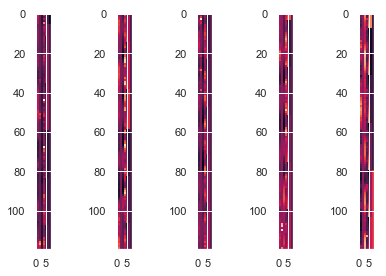

In [24]:
samples = [0, 500, 1000, 1500, 2000]

#plt.figure(figsize=(25,25))

for i, sample in enumerate(samples):
    i += 1
    plt.subplot(1,len(samples),i)
    plt.imshow(X_train[sample])


plt.tight_layout()

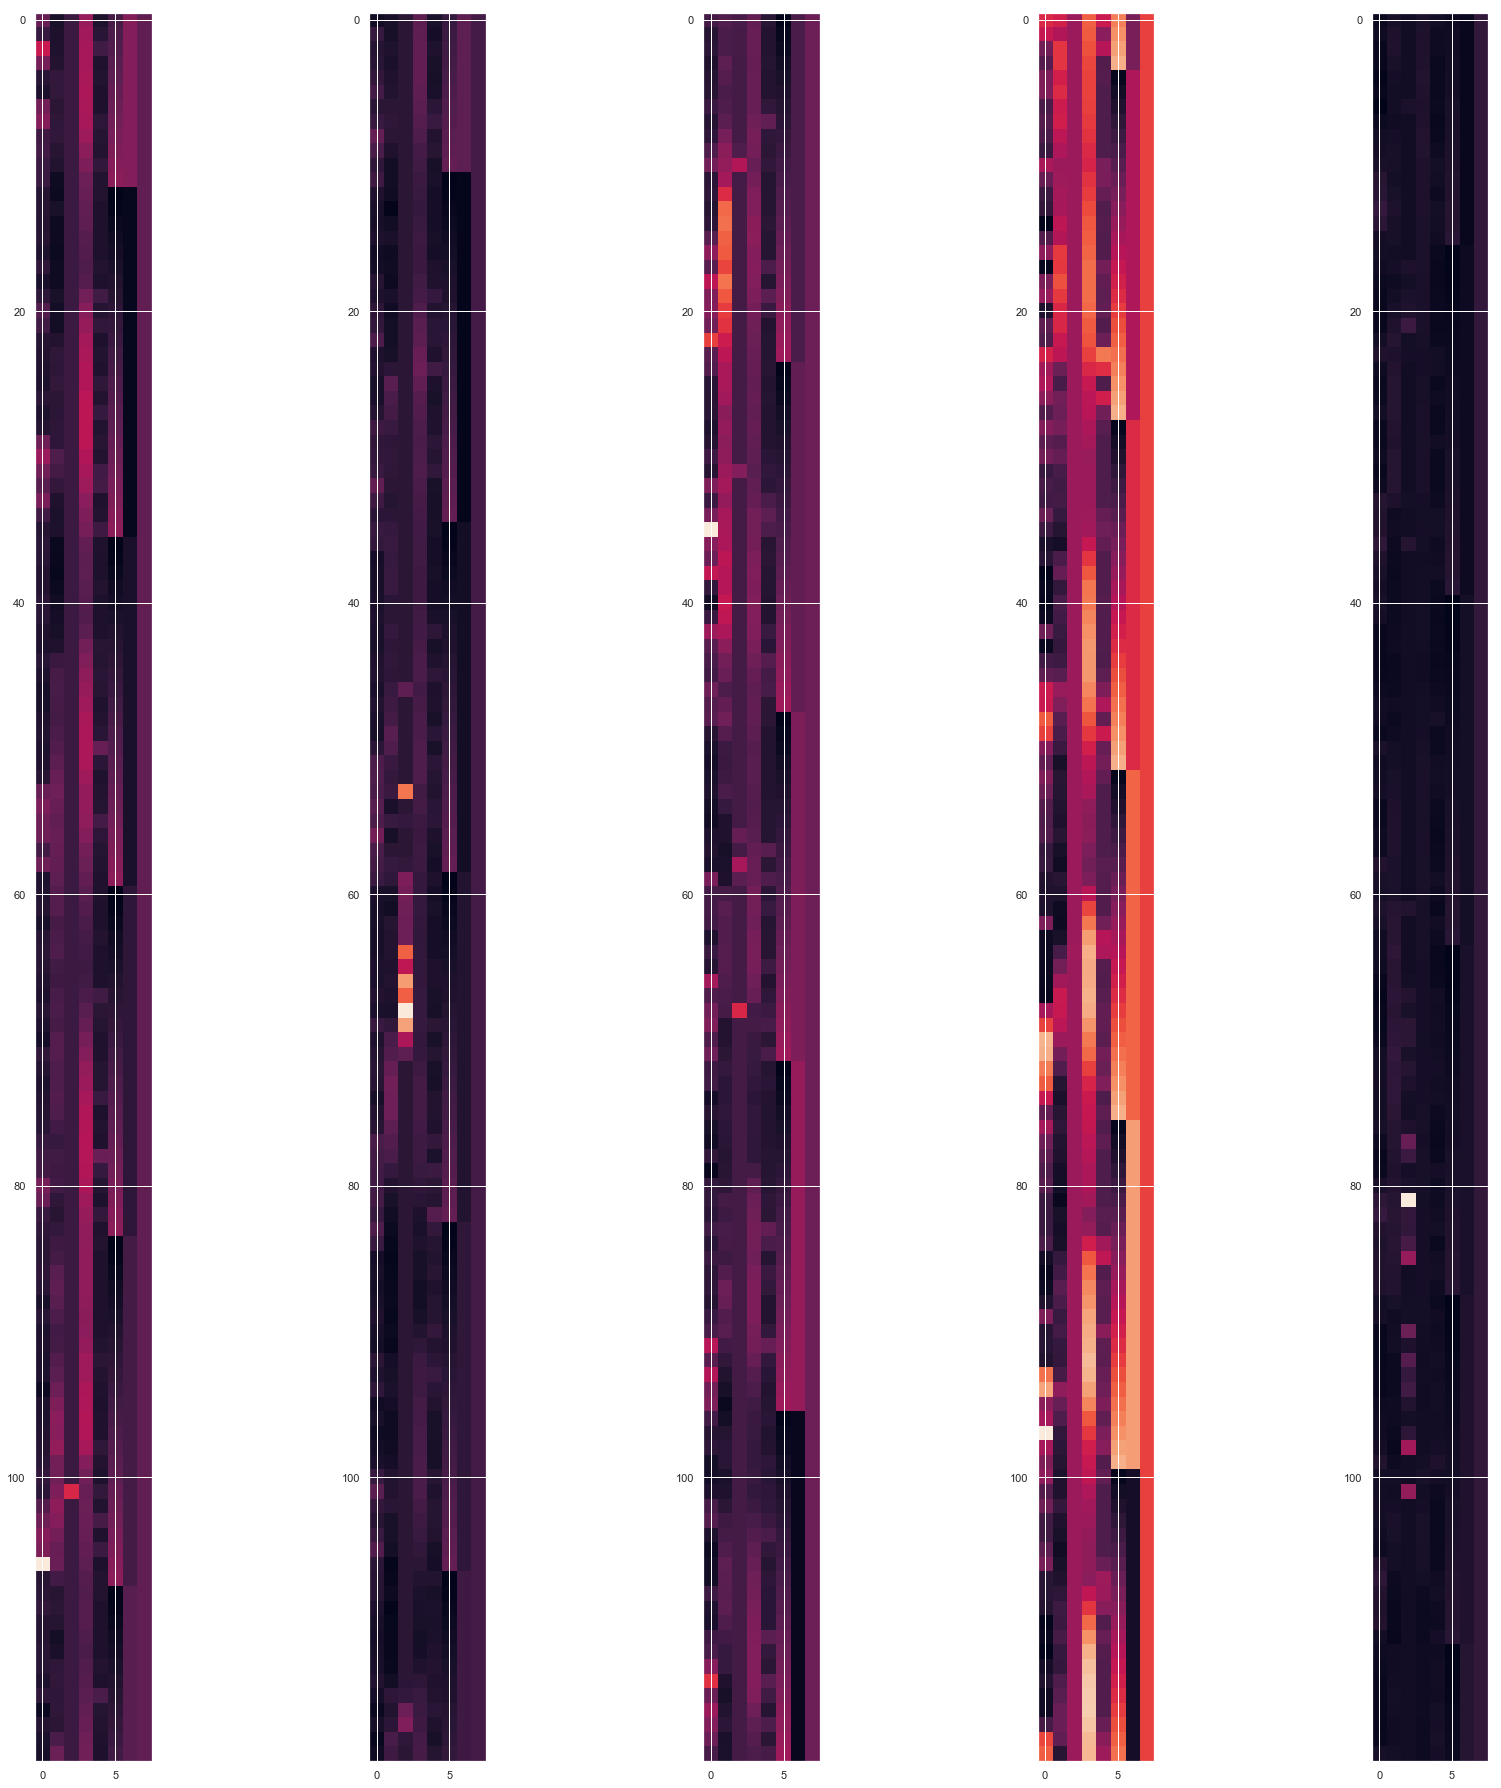

In [25]:
samples = [2500, 3000, 3500, 4000, 4300]

plt.figure(figsize=(25,25))

for i, sample in enumerate(samples):
    i += 1
    plt.subplot(1,len(samples),i)
    plt.imshow(X_train[sample])


plt.tight_layout()


In [26]:
# Make the image wider

In [27]:
a = X_train[0][:10, :5]
a.shape

(10, 5)

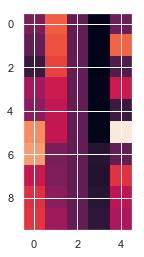

In [28]:
plt.imshow(a)

(10, 50)


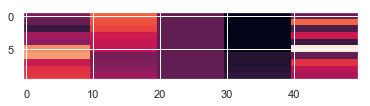

In [29]:
# 'stretch' the columns out by 10 pixels each. 
# i.e. copy the columns 10 times and add them next to each other. 
q = np.repeat(a[:,:], 10, axis=1)
print(q.shape)
plt.imshow(q)

(50, 50)


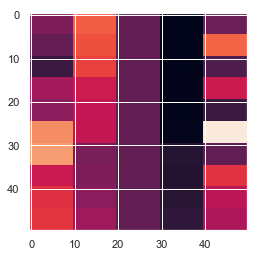

In [30]:
s = np.repeat(q[:,:], 5, axis=0)
print(s.shape)
plt.imshow(s)

# Apply this to the original 120 by 14 arrays

In [31]:
def transform_image(array, heigth, width):
    """
    Array = numpy array
    Heigth is the amount of pisels that a single pixel will be stretched out with in the height dimension.
    Width is the amount of pixels that a single pixel will be stretched out with in the width dimension.
    """
    array = array.copy()
    #print('Original shape: ', array.shape)
    array = np.repeat(array[:,:], width, axis=1)
    array = np.repeat(array[:,:], heigth, axis=0)
    #print('Transformed shape: ', array.shape)
    
    return array

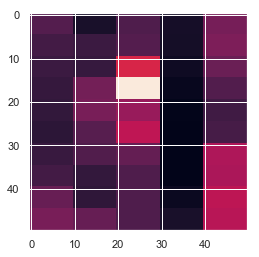

In [32]:
# Test the function. Plot the first 50 rows and columns.
plt.imshow(transform_image(X_train[1000, :, :], heigth=5, width=10)[:50, :50]) # Take

In [33]:
# What's left now is applying the above transform to all ... amount of 'images' from the dataframe.

In [34]:
reshaped = []
for i in range(X_train.shape[0]):
    reshaped.append(transform_image(X_train[i, :, :], heigth=5, width=10))
    
print('DONE')

DONE


In [35]:
np.array(reshaped).shape

(4326, 600, 80)

There are 4326 images of (600,80), where 600 is the height and width 80.  
In the actual CNN notebooks this 'stretched out' image is not used.  
They might be used for transfer learning however, to get something close to the 256 by 256 size which most ConvNets require.  